In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook
import warnings  
import time
warnings.filterwarnings('ignore')

# write fake submission file 
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = 0
sub.to_csv('submission.csv',index=False)

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
if len(test) < 150000:
    [].shape
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]
print(train.shape, test.shape)

AttributeError: 'list' object has no attribute 'shape'

In [2]:
oof = np.zeros(len(train))
preds = np.zeros(len(test))

for i in tqdm_notebook(range(512)):

    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)

    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    data2 = VarianceThreshold(threshold=2).fit_transform(data[cols])
    train3 = data2[:train2.shape[0]]; test3 = data2[train2.shape[0]:]

    skf = StratifiedKFold(n_splits=11, random_state=42)
    for train_index, test_index in skf.split(train2, train2['target']):

        clf = QuadraticDiscriminantAnalysis(0.5)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
        preds[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits

auc = roc_auc_score(train['target'], oof)
print(f'AUC: {auc:.5}')

test['target'] = preds
test.loc[test['target'] > 0.955, 'target'] = 1 # initial 94
test.loc[test['target'] < 0.045, 'target'] = 0 # initial 06
usefull_test = test[(test['target'] == 1) | (test['target'] == 0)]
new_train = pd.concat([train, usefull_test]).reset_index(drop=True)
print(usefull_test.shape[0], "Test Records added")
new_train.loc[oof > 0.99, 'target'] = 1 # initial 98
new_train.loc[oof < 0.01, 'target'] = 0 # initial 02

NameError: name 'cols' is not defined

In [3]:
#from sklearn.mixture import BayesianGaussianMixture as bgm
from sklearn.mixture import GaussianMixture as bgm
import time

def count(x):
    ret = [0,0,0,0,0,0]
    for i in x:
        ret[i] += 1
    return ret

def get_clf(data, data_pos, data_neg):
    start = time.time()
    while True:
        clf = bgm(n_components=6, covariance_type="full")
        clf.fit(data)
        p1 = count(clf.predict(data_pos))
        p2 = count(clf.predict(data_neg))
        flag = True
        up = len(data_pos)/3.6
        low = len(data_pos)/30
        for i in range(6):
            flag &= (p1[i] > up and p2[i] < low) or (p2[i] > up and p1[i] < low)
        t = time.time() - start
        if t > 40:
            return None, None
        if flag:
            #print(p1)
            #print(p2)
            pindex = set()
            for i in range(6):
                if p1[i] > 99:
                    pindex.add(i)
            return pindex, clf

In [4]:
poof = np.zeros(len(train))
ppreds = np.zeros(len(test))

for i in tqdm_notebook(range(512)):
    ptrain = train[train['wheezy-copper-turtle-magic']==i]
    ptrain_add = new_train[new_train['wheezy-copper-turtle-magic']==i]
    ptest = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train[train['wheezy-copper-turtle-magic']==i].index
    idx2 = test[test['wheezy-copper-turtle-magic']==i].index
    ptrain_add.reset_index(drop=True,inplace=True)
    ptest.reset_index(drop=True,inplace=True)
    sel = VarianceThreshold(threshold=1.5).fit(ptrain[cols])
    ptrain_np = sel.transform(ptrain[cols])
    ptrain_add_np = sel.transform(ptrain_add[cols])
    ptest_np = sel.transform(ptest[cols])
    
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(ptrain_add_np, ptrain_add['target']):
        test_index3 = test_index[ test_index<len(ptrain) ] # ignore pseudo in oof

        # MODEL AND PREDICT WITH QDA
        clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        clf.fit(ptrain_add_np[train_index,:],ptrain_add.loc[train_index]['target'])
        poof[idx1[test_index3]] = clf.predict_proba(ptrain_add_np[test_index3,:])[:,1]
        ppreds[idx2] += clf.predict_proba(ptest_np)[:,1] / skf.n_splits
    auc1 = roc_auc_score(ptrain['target'], poof[idx1])
    print(round(auc1,5))
    ptrain_add_pos = ptrain_add[ptrain_add['target'] == 1]
    ptrain_add_neg = ptrain_add[ptrain_add['target'] == 0]
    ptrain_add_pos_np = sel.transform(ptrain_add_pos[cols])
    ptrain_add_neg_np = sel.transform(ptrain_add_neg[cols])
    
    pindex, clf = get_clf(ptrain_add_np, ptrain_add_pos_np, ptrain_add_neg_np)
    if clf:
        ppp = clf.predict(ptrain_np)
        pppt = clf.predict(ptest_np)
        pr = clf.predict_proba(ptest_np)
        preds = []
        pt = []
        for k in ppp:
            if k in pindex:
                preds.append(1)
            else:
                preds.append(0)
        for i, k in enumerate(pppt):
            if k in pindex:
                pt.append(pr[i][k])
            else:
                pt.append(1 - pr[i][k])
        auc2 = roc_auc_score(ptrain['target'],preds)
        poof[idx1] = preds
        ppreds[idx2] = pt
    print(round(auc1,5) ,round(auc2,5))

auc = roc_auc_score(train['target'],poof)
print('QDA scores CV =',round(auc,5))

NameError: name 'new_train' is not defined

In [5]:
test['target'] = ppreds
test.loc[test['target'] > 0.955, 'target'] = 1 # initial 94
test.loc[test['target'] < 0.045, 'target'] = 0 # initial 06
usefull_test = test[(test['target'] == 1) | (test['target'] == 0)]
new_train = pd.concat([train, usefull_test]).reset_index(drop=True)
print(usefull_test.shape[0], "Test Records added")
new_train.loc[poof > 0.99, 'target'] = 1 # initial 98
new_train.loc[poof < 0.01, 'target'] = 0 # initial 02

poof = np.zeros(len(train))
ppreds = np.zeros(len(test))

for i in tqdm_notebook(range(512)):
    ptrain = train[train['wheezy-copper-turtle-magic']==i]
    ptrain_add = new_train[new_train['wheezy-copper-turtle-magic']==i]
    ptest = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train[train['wheezy-copper-turtle-magic']==i].index
    idx2 = test[test['wheezy-copper-turtle-magic']==i].index
    ptrain_add.reset_index(drop=True,inplace=True)
    ptest.reset_index(drop=True,inplace=True)
    sel = VarianceThreshold(threshold=1.5).fit(ptrain[cols])
    ptrain_np = sel.transform(ptrain[cols])
    ptrain_add_np = sel.transform(ptrain_add[cols])
    ptest_np = sel.transform(ptest[cols])
    
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(ptrain_add_np, ptrain_add['target']):
        test_index3 = test_index[ test_index<len(ptrain) ] # ignore pseudo in oof

        # MODEL AND PREDICT WITH QDA
        clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        clf.fit(ptrain_add_np[train_index,:],ptrain_add.loc[train_index]['target'])
        poof[idx1[test_index3]] = clf.predict_proba(ptrain_add_np[test_index3,:])[:,1]
        ppreds[idx2] += clf.predict_proba(ptest_np)[:,1] / skf.n_splits
    auc1 = roc_auc_score(ptrain['target'], poof[idx1])
    print(round(auc1,5))
    ptrain_add_pos = ptrain_add[ptrain_add['target'] == 1]
    ptrain_add_neg = ptrain_add[ptrain_add['target'] == 0]
    ptrain_add_pos_np = sel.transform(ptrain_add_pos[cols])
    ptrain_add_neg_np = sel.transform(ptrain_add_neg[cols])
    
    pindex, clf = get_clf(ptrain_add_np, ptrain_add_pos_np, ptrain_add_neg_np)
    if clf:
        ppp = clf.predict(ptrain_np)
        pppt = clf.predict(ptest_np)
        pr = clf.predict_proba(ptest_np)
        preds = []
        pt = []
        for k in ppp:
            if k in pindex:
                preds.append(1)
            else:
                preds.append(0)
        for i, k in enumerate(pppt):
            if k in pindex:
                pt.append(pr[i][k])
            else:
                pt.append(1 - pr[i][k])
        auc2 = roc_auc_score(ptrain['target'],preds)
        if auc1 - auc2 > 0.004:
            poof[idx1] = preds
            ppreds[idx2] = (np.array(pt) + ppreds[idx2]) / 2
        else:
            ppreds[idx2] = pt
    print(round(auc1,5) ,round(auc2,5))

auc = roc_auc_score(train['target'],poof)
print('QDA scores CV =',round(auc,5))

131073 Test Records added


NameError: name 'cols' is not defined

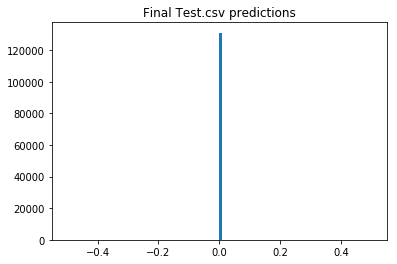

In [6]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = ppreds
sub.to_csv('submission.csv',index=False)

import matplotlib.pyplot as plt
plt.hist(ppreds,bins=100)
plt.title('Final Test.csv predictions')
plt.show()